# Imports

## Imports

In [26]:
from simpledbf import Dbf5
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import json
%matplotlib inline
datos_dir = '/Users/admin/Desktop/Dataton Carcelario/BDs/indice_prisiones/enpol/'
with open('diccionario_cve_entidad.json', encoding='utf-8') as d_ent_file:
    diccionario_cve_entidad = json.load(d_ent_file)

## Funciones


In [27]:
def dbf_to_csv(inputfile, outputfile='output'):
    Dbf5(inputfile, codec='latin-1').to_dataframe().to_csv(outputfile, sep=',', index=False)
    
def asigna_cve_entidad(x, nacional=True):
    """Función que asigna la clave Inegi si detecta el nombre de la entidad.
    nacional indica si se asigna también un código cuando se refiere al valor Nacional"""
    if not nacional:
        del diccionario_cve_entidad['00']
    for c in diccionario_cve_entidad:
        out = ''
        if re.search(sin_acento(diccionario_cve_entidad[c]),sin_acento(x), flags=re.I|re.A):
            out = c
            break
    return out

def sin_acento(x):
    output = x.replace('á','a').replace('é','e').replace('í','i').replace('ó','o').replace('ú','u')\
            .replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U')
    return output


# De dbf a csv

In [28]:
files = glob.glob1(datos_dir, '*.dbf')
for f in files:
    csvname= datos_dir+f.replace('dbf', 'csv')
    if not os.path.exists(csvname):
        dbf_to_csv(datos_dir+f, outputfile=csvname)

# Índice corrupción

In [29]:
print(datos_dir+'ENPOL_SEC8_9_10.csv')
corrup = pd.read_csv(datos_dir+'ENPOL_SEC8_9_10.csv', index_col='ID_PER')

/Users/admin/Desktop/Dataton Carcelario/BDs/indice_prisiones/enpol/ENPOL_SEC8_9_10.csv


* 8.2 Durante 2016, un servidor público, empleado del gobierno o custodio: 
    * 8.2.1 ¿INTENTÓ apropiarse o le PIDIÓ de forma directa algún benefcio como dinero, bienes, regalos o favores?
    * 8.2.2 ¿a través de un interno o abogado, le PIDIÓ dinero, bienes, regalos o favores?
    * 8.2.3 ¿le INSINUÓ o GENERÓ las condiciones para que usted le proporcionara dinero, bienes, regalos o favores?
* 8.3 Dígame por favor, durante 2016, ¿por cuáles servicios, bienes, benefcios o permisos, paga usted dentro del Centro penitenciario
    * 8.3.1 Usar baños, mingitorios y/o regaderas
    * 8.3.2 Tener agua potable
    * 8.3.3 Tener energía eléctrica en su celda
    * 8.3.4 Tener una cama, colchoneta y/o cobijas
    * 8.3.5 Recibir comida (rancho)
    * 8.3.6 Salir a patio de visita
    * 8.3.7 Ir a juzgados
    * 8.3.8 Ir a locutorios
    * 8.3.9 El pase de lista
    * 8.3.10 Acceder a visita conyugal
    * 8.3.11 Acceder a servicios médicos, psicológicos o escolares
    * 8.3.12 Participar en algún taller
    * 8.3.13 Tener aparatos eléctricos
    * 8.3.14 Tener dispositivos electrónicos de comunicación
    * 8.3.15 Cambiar de celda (evitar o cambiar de celda)
    * 8.3.16 Tener acceso a un teléfono
    * 8.3.17 Protección
    * 8.3.18 Otro
* 8.4 ¿A quién(es) ha tenido que pagar durante 2016 por lo que mencionó anteriormente?
    * 8.4.2 Custodios
    * 8.4.3 Personal técnico penitenciario
    * 8.4.4 Personal médico
    * 8.4.5 Personal administrativo
* 8.7 De los pagos antes mencionados, ¿usted denunció ante alguna autoridad?
* 8.9 Durante 2016, la(s) persona(s) que ha(n) venido a visitarlo, ¿ha(n) tenido que pagar por..
    * 8.9.1 pasar la comida?
    * 8.9.2 pasar la ropa?
    * 8.9.3 pasar otros objetos?
    * 8.9.4 mandarlo a llamar?
    * 8.9.5 entrar al centro?
    * 8.9.6 tener visita conyugal?
    * 8.9.7 Otro
* 8.10 De lo mencionado anteriormente, ¿a quién(es) ha(n) tenido que pagar sus visitas?
    * 8.10.2 Custodios
    * 8.10.3 Personal técnico penitenciario
    * 8.10.4 Personal administrativo
    * 8.10.5 Médicos
    
    
    

In [30]:
# Corrupción
varP8_2 = [f'P8_2_{x}' for x in range(1, 4)]
varP8_3 = [f'P8_3_{str(x).zfill(2)}' for x in range(1, 19)]
varP8_4 = [f'P8_4_{x}' for x in range(2, 6)]
varP8_7 = ['P8_7']
varP8_9 = [f'P8_9_{x}' for x in range(1, 8)]
varP8_10 = [f'P8_10_{x}' for x in range(2, 6)]
varP8 = varP8_2 + varP8_3 + varP8_7 + varP8_9
dfs_corrup = {'general': corrup,
       'mujeres': corrup.query('SEXO==2'),
       'hombres': corrup.query('SEXO==1'),
       'federal': corrup.query('FUERO==1'),
       'est_mun': corrup.query('FUERO==2')}
L_corrup = dict()
# Población privada de libertad
for d in dfs_corrup:
    corrup = dfs_corrup[d]
    pob = corrup.groupby('CVE_ENT')['FAC_PER'].sum()
    score_corrup = corrup[varP8+['CVE_ENT','FAC_PER']]\
        .replace({'P8_7': {1:3}})\
        .replace({'P8_7': {2:1}})\
        .groupby(['CVE_ENT'])\
        .agg(lambda x: ((x[varP8]==1).apply(lambda y: y*x['FAC_PER'])).sum())\
        .apply(lambda x: 100*(x/pob))\
        .assign(corrupcion=lambda x: x.sum(axis=1))\
        .assign(corrupcion_n=lambda x:
                (x['corrupcion']-x['corrupcion'].min())/(x['corrupcion'].max()-x['corrupcion'].min()))
    L_corrup[d] = score_corrup

# Indice Inseguridad

In [32]:
seg = pd.read_csv(datos_dir+'ENPOL_SEC7_1.csv', index_col='ID_PER')

* 7.47 Durante 2016, ¿a usted le ha sucedido el (CÓDIGO DE SITUACIÓN)?
    * 7.47.1 Le han robado objetos personales
    * 7.47.2 Lo han amenazado o presionado para exigirle dinero o bienes (extorsión)
    * 7.47.3 Lo han amenazado o presionado para que hiciera algo o dejara de hacerlo
    * 7.47.4 Alguien, solo por actitud abusiva o por una discusión, lo golpeó generándole una lesión física (moretones, fracturas, cortadas, etcétera)
    * 7.47.5 Lo han agredido mediante hostigamiento sexual, manoseo, exhibicionismo o intento de violación
    * 7.47.6 Lo han obligado mediante violencia física o amenaza a tener una actividad sexual no deseada (violación sexual)
* 7.49 ¿Quién(es) los han agredido de la forma que mencionó? 
    * 7.49.1 Le han robado objetos personales
        * 7.49.1.2 Custodios
        * 7.49.1.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.1.4 Personal médico
    * 7.49.2 Lo han amenazado o presionado para exigirle dinero o bienes (extorsión)
        * 7.49.2.2 Custodios
        * 7.49.2.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.2.4 Personal médico
    * 7.49.3 Lo han amenazado o presionado para que hiciera algo o dejara de hacerlo
        * 7.49.3.2 Custodios
        * 7.49.3.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.3.4 Personal médico
    * 7.49.4 Alguien, solo por actitud abusiva o por una discusión, lo golpeó generándole una lesión física (moretones, fracturas, cortadas, etcétera)
        * 7.49.4.2 Custodios
        * 7.49.4.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.4.4 Personal médico
    * 7.49.5 Lo han agredido mediante hostigamiento sexual, manoseo, exhibicionismo o intento de violación
        * 7.49.5.2 Custodios
        * 7.49.5.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.5.4 Personal médico
    * 7.49.6 Lo han obligado mediante violencia física o amenaza a tener una actividad sexual no deseada (violación sexual)
        * 7.49.6.2 Custodios
        * 7.49.6.3 Personal técnico penitenciario (psicólogos, trabajadores sociales, criminólogos, secretarios)
        * 7.49.6.4 Personal médico    

In [33]:
# seguridad
varP7_47 = [f'P7_47_{x}' for x in range(1, 7)]
varP7_49 = [f'P7_49_{i}_{x}' for x in range(2, 5) for i in range(1,7)]
varP7 = varP7_47+varP7_49

dfs_seg = {'general': seg,
       'mujeres': seg.query('SEXO==2'),
       'hombres': seg.query('SEXO==1'),
       'federal': seg.query('FUERO==1'),
       'est_mun': seg.query('FUERO==2')}
L_seg = dict()
for d in dfs_seg:
    seg = dfs_seg[d]
    # Población privada de libertad
    pob = seg.groupby('CVE_ENT')['FAC_PER'].sum()
    score_seg = seg[varP7+['CVE_ENT', 'FAC_PER']]\
        .groupby('CVE_ENT')\
        .agg(lambda x: ((x[varP7]==1).apply(lambda y: y*x['FAC_PER'])).sum())\
        .apply(lambda x: 100*(x/pob))\
        .assign(inseguridad=lambda x: x.sum(axis=1))\
        .assign(inseguridad_n=lambda x:
                (x['inseguridad']-x['inseguridad'].min())/(x['inseguridad'].max()-x['inseguridad'].min()))
    L_seg[d] = score_seg

# Índice de servicios básicos

In [35]:
serv = pd.read_csv(datos_dir+'ENPOL_SEC_5_6.csv', index_col='ID_PER')

* 6.2 ¿Cuenta con cama propia?
* 6.3 Regularmente, ¿comparte su/alguna cama, camastro o colchoneta con otra persona?
* 6.4 Regularmente, ¿su celda está limpia?
* 6.5 Por favor, dígame si SU CELDA cuenta con:
    * 6.5.1 Agua potable
    * 6.5.2 Drenaje
    * 6.5.3 Luz eléctrica (Energía eléctrica)
    * 6.5.4 Lugar para bañarse y hacer del baño
* 6.6 ¿Hay un área común para bañarse y hacer del baño?
* 6.7 De acuerdo con su experiencia, ¿el agua potable en su celda...
    * 6.7.1 es pura y transparente?
    * 6.7.2 es bebible sin temor a enfermarse?
    * 6.7.3 tiene servicio constante?
* 6.9 De acuerdo con su experiencia, ¿el drenaje en su celda..
    * 6.9.1 está conectado de tal forma que los desechos se descargan adecuadamente?
    * 6.9.2 recibe mantenimiento frecuente que evita olores desagradables y plagas (cucarachas, ratas, etc.)?
    * 6.9.3 presenta fugas de aguas negras por ruptura en el drenaje?
* 6.11 De acuerdo con su experiencia, ¿el servicio de luz eléctrica (energía eléctrica) en su celda...
    * 6.11.1 ilumina adecuadamente?
    * 6.11.2 genera la luz sufciente para que usted pueda leer o trabajar sin lastimarse la vista?
    * 6.11.3 en caso de falla se da atención inmediata a la falta de energía eléctrica?
* 6.13 De acuerdo con su experiencia, ¿el lugar para bañarse y hacer del baño...
    * 6.13.1 cuenta con regaderas para que usted pueda bañarse?
    * 6.13.2 cuenta con un espacio para hacer del baño (sanitarios)?
    * 6.13.3 cuenta con lavamanos?
    * 6.13.4 está limpio?
* 6.15 ¿El Centro le ha proporcionado (RENGLÓN)...
    * 6.15.1 servicios médicos?
    * 6.15.2 medicamentos?
    * 6.15.3 alimentos?
* 6.17 ¿El Centro le ha proporcionado (RENGLÓN)...
    * 6.17.1 ropa (uniformes)?
    * 6.17.2 calzado?
    * 6.17.3 cobijas?
    * 6.17.4 artículos de limpieza personal (jabón, papel higiénico, pasta de dientes, etcétera)?   

In [36]:
# seguridad
varP6_G1 = ['P6_2', 'P6_3', 'P6_4', 'P6_6']
varP6_G2 = [f'P6_{j}_{x}' for x in range(1, 5) for j in [5, 13, 17]]
varP6_G3 = [f'P6_{j}_{x}' for x in range(1, 4) for j in [7, 9, 11, 15]]
varP6 = varP6_G1+varP6_G2+varP6_G3

dfs_serv = {'general': serv,
       'mujeres': serv.query('SEXO==2'),
       'hombres': serv.query('SEXO==1'),
       'federal': serv.query('FUERO==1'),
       'est_mun': serv.query('FUERO==2')}
L_serv = dict()
for d in dfs_serv:
    serv = dfs_serv[d]
    # Población privada de libertad
    pob = serv.groupby('CVE_ENT')['FAC_PER'].sum()
    score_serv = serv[varP6+['CVE_ENT', 'FAC_PER']]\
        .replace({'P6_3': {2:3}})\
        .replace({'P6_3': {1:2}})\
        .groupby('CVE_ENT')\
        .agg(lambda x: ((x[varP6]==2).apply(lambda y: y*x['FAC_PER'])).sum())\
        .apply(lambda x: 100*(x/pob))\
        .assign(servicios=lambda x: x.sum(axis=1))\
        .assign(servicios_n=lambda x:
                (x['servicios']-x['servicios'].min())/(x['servicios'].max()-x['servicios'].min()))
    L_serv[d] = score_serv

# sobrepoblación

In [37]:
sobrepob = pd.read_csv('../observatorio/privadas_libertad.csv')\
    .query('year==2017 & entidad!="Sistema Federal"')[['sobrepoblacion_rel', 'entidad', 'g_a_total']]\
    .assign(cve_ent=lambda x: x['entidad'].apply(asigna_cve_entidad).astype(int),
           sobrepoblacion_n = lambda x:
           (x['sobrepoblacion_rel']-x['sobrepoblacion_rel'].min())/(x['sobrepoblacion_rel'].max()-x['sobrepoblacion_rel'].min()))\
    .rename(columns={'g_a_total': 'pob'})\
    .dropna(subset=['cve_ent'])\
    .set_index('cve_ent')

# Violencia

In [38]:
viol = pd.read_csv('../observatorio/violencia_prisiones.csv')\
    .query('year==2017')\
    .rename(columns={'state_code': 'cve_ent', 'total': 'violencia'})\
    .set_index('cve_ent')\
    .drop(['entidad', 'year'], axis=1)\
    .apply(lambda x: 1000*(x/sobrepob['pob']))\
    .assign(violencia_n=lambda x:
           (x['violencia']-x['violencia'].min())/(x['violencia'].max()-x['violencia'].min()))
viol

,Intentos de fuga,fuga,motines,riñas,Homicidio,Intento de homicidio,intento de suicidio,Suicidio,Huelgas de Hambre,Decesos,Intentos de Violación,Violaciones,Agresiones a terceros,Autoagresiones,violencia,violencia_n
cve_ent,,,,,,,,,,,,,,,,
0,0.018448,0.041507,0.216759,4.570380,0.313608,0.027671,0.096850,0.225982,0.069178,1.277493,0.013836,0.009224,2.112244,1.457356,10.450535,0.145680
1,0.000000,0.000000,0.000000,0.786782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.786782,0.010968
2,0.079202,0.000000,0.633613,7.682560,0.000000,0.000000,0.079202,0.000000,0.079202,0.475210,0.237605,0.000000,8.632980,1.108823,19.008395,0.264977
3,1.293661,0.646831,0.646831,5.821475,1.293661,0.000000,0.000000,0.000000,0.000000,2.587322,0.000000,0.000000,9.055627,1.940492,23.285899,0.324605
4,0.000000,0.000000,0.700280,15.406162,0.000000,0.000000,0.000000,0.700280,0.000000,0.000000,0.000000,0.700280,2.801120,1.400560,21.708683,0.302619
7,0.000000,0.000000,0.000000,17.191977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.220410,1.102050,18.514437,0.258091
8,0.000000,0.000000,0.750563,12.884663,0.125094,0.375281,1.000751,0.875657,0.000000,2.501876,0.000000,0.000000,3.752815,4.003002,26.269702,0.366200
5,0.000000,0.000000,0.909504,6.366530,0.454752,0.000000,0.000000,3.183265,5.002274,25.920873,0.000000,0.000000,5.457026,0.000000,47.294225,0.659281
6,0.000000,0.000000,0.000000,32.608696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418060,2.090301,35.117057,0.489532


# DDHH

In [39]:
dh = pd.read_csv('../observatorio/supervision_penitenciaria.csv')\
    .query('year==2017 & cal_general!="No visitado"')\
    .dropna(subset=['direccion'])\
    .assign(cve_ent=lambda x: x['entidad'].apply(asigna_cve_entidad))\
    .astype({'cal_general': float, 'integridad_fisica_moral': float, 'estancia_digna': float, 'gobernabilidad': float, 'reinsercion_social': float})
dh.loc[dh['entidad']=="Centros Federales", 'cve_ent'] = dh.loc[dh['entidad']=="Centros Federales", 'direccion']\
    .fillna('')\
    .apply(asigna_cve_entidad)
ddhh = dh.astype({'cve_ent': int})\
    .groupby('cve_ent').mean()\
    [['cal_general', 'integridad_fisica_moral', 'estancia_digna', 'gobernabilidad', 'reinsercion_social']]\
    .rename(columns={'cal_general': 'ddhh'})\
    .assign(ddhh_n=lambda x:
           (x['ddhh']-x['ddhh'].min())/(x['ddhh'].max()-x['ddhh'].min()))

In [40]:
ddhh

,ddhh,integridad_fisica_moral,estancia_digna,gobernabilidad,reinsercion_social,ddhh_n
cve_ent,,,,,,
1,7.613333,8.436667,7.636667,8.186667,7.853333,0.868769
2,7.510000,6.902500,7.425000,8.300000,6.822500,0.842352
3,5.090000,5.700000,5.066667,4.443333,5.283333,0.223690
4,6.825000,7.495000,5.940000,6.740000,6.545000,0.667235
5,7.738000,7.766000,7.616000,8.480000,7.322000,0.900639
6,7.090000,6.783333,7.010000,7.176667,7.340000,0.734981
7,6.166000,6.570000,6.342000,6.720000,6.014000,0.498764
8,7.272857,7.287143,7.510000,8.548571,7.295714,0.781727
9,6.875455,6.629091,7.220000,6.481818,7.152727,0.680133


# CNGSPSP

## población

In [41]:
cn_pob = pd.read_excel('../CNGSJSP/CNGSPSPE2018_M3.xlsx', sheet_name='3.3', header=4, skipfooter=7)\
    .dropna(subset=['Entidad Federativa'])\
    .assign(cve_ent=lambda x: x['Entidad Federativa'].apply(asigna_cve_entidad).astype(int))\
    .set_index('cve_ent')\
    [['Total']]

## Presupuesto ejercido (miles de pesos)

In [42]:
# Presupuesto en miles de pesos
presup = pd.read_excel('../CNGSJSP/CNGSPSPE2018_M3.xlsx', sheet_name='3.6', header=5, skipfooter=10)\
    .dropna(subset=['Entidad Federativa'])\
    .assign(cve_ent=lambda x: x['Entidad Federativa'].apply(asigna_cve_entidad).astype(int))\
    .assign(presupuesto=lambda x: x['Ejercido3'].replace({'-': pd.np.nan}))\
    .set_index('cve_ent')\
    .join(cn_pob)\
    .assign(presup_pi=lambda x: x['presupuesto']/x['Total'])\
    .pipe(lambda df: df.fillna({'presup_pi': df['presup_pi'].mean()}))\
    [['presupuesto', 'presup_pi']]

## Recursos humanos (internos por cada trabajador)

In [43]:
interno_pt = pd.read_excel('../CNGSJSP/CNGSPSPE2018_M3.xlsx', sheet_name='3.5', header=5, skipfooter=6)\
    .dropna(subset=['Entidad Federativas'])\
    .assign(cve_ent=lambda x: x['Entidad Federativas'].apply(asigna_cve_entidad).astype(int))\
    .rename(columns={'Total': 'personal'})\
    .set_index('cve_ent')\
    .join(cn_pob)\
    .assign(interno_pt=lambda x: x['Total']/x['personal'])\
    [['personal', 'interno_pt']]
cng = presup.join(interno_pt)

# Indice multidimensional

In [45]:
W_corrupcion = 0.15
W_inseguridad = 0.15
W_servicios = 0.1
W_violencia = 0.15
W_sobrepoblacion = 0.1
W_ddhh = 0.15
W_presup = 0.1
W_interno = 0.1
W = pd.np.array([W_corrupcion, W_inseguridad, W_servicios, W_violencia, W_sobrepoblacion, W_ddhh, W_presup, W_interno])

indice_multi_pre = dict()
indice_multi = dict()
for d in ['general', 'mujeres', 'hombres', 'federal', 'est_mun']:
    indice = pd.concat([L_corrup[d], L_seg[d], L_serv[d]], axis=1)
    indice_multi_pre[d] = indice[['corrupcion', 'inseguridad', 'servicios']]\
        .join([viol[['violencia']], sobrepob[['sobrepoblacion_rel']], ddhh[['ddhh']], cng[['presup_pi', 'interno_pt']]])
    indice_multi[d] =  indice_multi_pre[d]\
        .apply(lambda x: (x-x.min())/(x.max()-x.min()))\
        .assign(ddhh=lambda x: 1-x['ddhh'], presup_pi=lambda x: 1-x['presup_pi'])\
        .assign(indice=lambda x: (x*W).sum(axis=1))
    indice_multi.to_csv(f'indice_multidimensional_{d}.csv')

AttributeError: 'dict' object has no attribute 'to_csv'

In [46]:
dicc_entidad = {int(x): diccionario_cve_entidad[x].split('|')[0] for x in diccionario_cve_entidad}
indice_multi_pre.index = indice_multi_pre.index.map(dicc_entidad)

AttributeError: 'dict' object has no attribute 'index'

# Variables externas

* Violencia exterior (homicidios)
* Índice Estado de Derecho
* Pib per cápita
* Presupuesto per cápita
* Fiscalía por 100 hab
* Población



In [36]:
indice_multi_pre

,corrupcion,inseguridad,servicios,violencia,sobrepoblacion_rel,ddhh,presup_pi,interno_pt
CVE_ENT,,,,,,,,
Aguascalientes,36.747463,93.987991,643.612345,0.786782,-32.57,7.613333,21.118717,2.405063
Baja California(?!\s?sur),13.178673,38.971249,871.512049,19.008395,-14.82,7.510000,49.279730,7.943860
Baja California Sur,77.742222,94.143393,719.495769,23.285899,-10.84,5.090000,129.423272,2.794702
Campeche,16.644886,48.383587,645.705174,21.708683,-21.88,6.825000,66.776035,6.102679
Coahuila de Zaragoza,2.201829,16.118122,625.345001,47.294225,-38.70,7.738000,77.167550,7.292929
Colima,27.882443,58.782553,817.649992,35.117057,-53.15,7.090000,91.071768,4.537349
Chiapas,32.903900,35.990375,745.203977,18.514437,-1.48,6.166000,21.302312,2.459241
Chihuahua,72.398231,45.428495,485.489642,26.269702,4.96,7.272857,72.065807,6.158019
Ciudad de México,556.466654,109.560299,984.771184,0.325807,28.17,6.875455,120.049719,4.458099


In [ ]:

indice_multi_pre.index.map(dicc_entidad)

In [24]:
indice_multi_pre.corr()

,corrupcion,inseguridad,servicios,violencia,sobrepoblacion_rel,ddhh,presup_pi,interno_pt
corrupcion,1.000000,0.636991,0.621938,-0.122628,0.447226,0.027756,0.138051,-0.054471
inseguridad,0.636991,1.000000,0.524834,0.004026,0.236313,0.209621,0.408977,-0.493840
servicios,0.621938,0.524834,1.000000,0.032877,0.420029,-0.150476,-0.041112,0.058948
violencia,-0.122628,0.004026,0.032877,1.000000,-0.159898,0.277039,0.135884,-0.105803
sobrepoblacion_rel,0.447226,0.236313,0.420029,-0.159898,1.000000,-0.097031,-0.177679,0.328290
ddhh,0.027756,0.209621,-0.150476,0.277039,-0.097031,1.000000,0.356185,-0.266217
presup_pi,0.138051,0.408977,-0.041112,0.135884,-0.177679,0.356185,1.000000,-0.489293
interno_pt,-0.054471,-0.493840,0.058948,-0.105803,0.328290,-0.266217,-0.489293,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000172697F5278>,
      dtype=object)

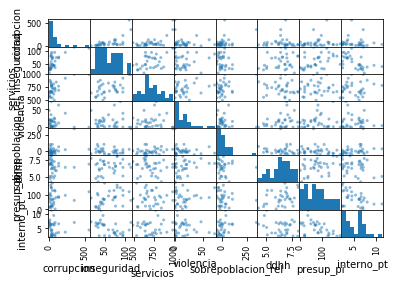

In [25]:
pd.plotting.scatter_matrix(indice_multi_pre)